In [3]:
import os
currentdir = os.getcwd()
correctdir = currentdir.rsplit('tv2ds/',1)[0]
os.chdir(correctdir)

from tv2ds.ds_lib import notebook_prodrun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tvsquared.settings
from tvsquared.lib.request import Request
from tvsquared.lib.athena import AthenaDatabase
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

In [4]:
notebook_prodrun.set_env('US', prodrunenv='PROD')
crosswalk_suffix = os.environ.get('TV2PRODRUNENV').lower()
crosswalk_suffix

'produsa'

## Athena query functions

In [5]:
def make_request(clientid, brandid = 1, datefrom=False, dateto=False):
    if datefrom and dateto:
        request = Request(clientarg=False, brandarg=False, datesarg=False)
        datefrom = datetime.datetime.strptime(datefrom, '%Y-%m-%d')
        dateto = datetime.datetime.strptime(dateto, '%Y-%m-%d')
        request = request.init(partnerid=None, clientid=clientid, brandid=brandid,datefrom=datefrom, dateto=dateto,loglevel=-1, extargs=None, request=None, usespark=None, readPreference=None,prodrun=False)
        return(request)
    else:
        request = Request(clientarg=False, brandarg=False, datesarg=False)
        request = request.init(partnerid=None, clientid=clientid, brandid=brandid,datefrom=None, dateto=None,loglevel=-1, extargs=None, request=None, usespark=None, readPreference=None,prodrun=False)
        return(request)


def query_athena(request, query, copy_to_local=False):
    athena_db = AthenaDatabase.get_client_database(request)
    query_results = AthenaDatabase.execute_query(athena_db, query, copy_to_local=copy_to_local)
    df = pd.DataFrame(query_results)
    return(df)

Client chosen: 9306

If you need a prod client, I see Drizly used for a lot of testing (it's client ID 9306 on prodUSA) so I think it should have a decent amount of data? For OTT Control Groups for instance we're looking at the preprev version over Feb and March 2022 so there should be data at least for that period if you want to try running a query for e.g. March 2022

Drizly - Beer, wine and liquor delivered to your doorstep

In [6]:
client = {'clientid': 9306}
request = make_request(client['clientid'])

### Test query

In [217]:
# Basic query
test_query = '''with filtered_hh as (
   select *
   from {crosswalk_suffix}_modeldata.crosswalk
   where yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='tv2_hhid' and vendor_name = '{vendor_name}' and excluded_stamp is null
)
select * 
from filtered_hh limit 10'''.format(vendor_name='inscape', yy='2022', mm='03',dd='28',crosswalk_suffix='produsa')

In [218]:
df_chio= query_athena(request, test_query)

In [219]:
df_chio

,key_value,excluded_stamp,excluded_reason,complex_range,region,demographics,vendor_name,key_name,yy,mm,dd
0,2182fb5b711e11eb87b206995247f54d,,,"[{mapped_tv2_hhid=2182fb5b711e11eb87b206995247f54d, first_seen=2021-02-16 04:47:42.000, last_seen=2021-12-06 00:00:00.000}]",US/west-coast/san-francisco-oakland-san-jose-ca,"[{vendor=experian, control_group_code=H29, vendor_hh_id=2498564194}]",inscape,tv2_hhid,2022,03,28
1,afbd9d6999d711ea9cdb02c488831410,,,"[{mapped_tv2_hhid=afbd9d6999d711ea9cdb02c488831410, first_seen=2020-03-31 22:08:04.000, last_seen=2022-04-06 00:00:00.000}]",US/mountain/albuquerque-santa-fe-nm,"[{vendor=experian, control_group_code=L42, vendor_hh_id=1859698275}]",inscape,tv2_hhid,2022,03,28
2,2fee2fbb03bd11eb93e006cd8937ee35,,,"[{mapped_tv2_hhid=2fee2fbb03bd11eb93e006cd8937ee35, first_seen=2020-09-30 03:05:38.000, last_seen=2022-04-06 00:00:00.000}]",US/central/evansville-in,"[{vendor=experian, control_group_code=E21, vendor_hh_id=1488766078}]",inscape,tv2_hhid,2022,03,28
3,93e8320f99ee11ea81a202f2311c42c0,,,"[{mapped_tv2_hhid=93e8320f99ee11ea81a202f2311c42c0, first_seen=2020-04-29 06:54:26.000, last_seen=2022-04-06 00:00:00.000}]",US/east-coast/springfield-holyoke-ma,"[{vendor=experian, control_group_code=P59, vendor_hh_id=1362720925}]",inscape,tv2_hhid,2022,03,28
4,b0b31f7b99d711ea84ec02fe1f1f008a,,,"[{mapped_tv2_hhid=b0b31f7b99d711ea84ec02fe1f1f008a, first_seen=2020-03-31 07:00:00.000, last_seen=2022-04-06 00:00:00.000}]",US/central/baton-rouge-la,"[{vendor=experian, control_group_code=N48, vendor_hh_id=1419839733}]",inscape,tv2_hhid,2022,03,28
5,6212e09aa9b711ec89de1df3a4621c0e,,,"[{mapped_tv2_hhid=6212e09aa9b711ec89de1df3a4621c0e, first_seen=2022-03-21 02:15:59.000, last_seen=2022-04-06 00:00:00.000}]",US/west-coast/fresno-visalia-ca,"[{vendor=experian, control_group_code=B07, vendor_hh_id=2100498789}]",inscape,tv2_hhid,2022,03,28
6,0fee7094a7f911ebac2406348abec611,,,"[{mapped_tv2_hhid=0fee7094a7f911ebac2406348abec611, first_seen=2021-04-27 23:10:29.000, last_seen=2022-04-06 00:00:00.000}]",US/central/chicago-il,"[{vendor=experian, control_group_code=I33, vendor_hh_id=2152684450}]",inscape,tv2_hhid,2022,03,28
7,1d8e8934573511ec8230f16dadc94cbe,,,"[{mapped_tv2_hhid=1d8e8934573511ec8230f16dadc94cbe, first_seen=2021-12-03 00:00:00.000, last_seen=2022-04-06 00:00:00.000}]",US/central/milwaukee-wi,"[{vendor=experian, control_group_code=Q65, vendor_hh_id=2757902035}]",inscape,tv2_hhid,2022,03,28
8,4646831a1c5011ec92e8d9dabfe9f691,,,"[{mapped_tv2_hhid=4646831a1c5011ec92e8d9dabfe9f691, first_seen=2021-09-22 16:10:22.000, last_seen=2021-09-26 23:59:59.999}]",,,inscape,tv2_hhid,2022,03,28
9,a8f988f66aae11eb8b0906abbbd44169,,,"[{mapped_tv2_hhid=a8f988f66aae11eb8b0906abbbd44169, first_seen=2021-02-08 23:25:57.000, last_seen=2021-03-30 21:15:29.000}]",US/central/houston-tx,,inscape,tv2_hhid,2022,03,28


Running full query to get final metrics:
- exp_visited	
- exp_hh	
- ctrl_visited	
- ctrl_hh	
- exp_vr	
- ctrl_vr	
- uplift

for March data from Drizly (client 9306)

Crosswalk week: yy='2022', mm='03',dd='28' <br>
Campaing dates: dateto='2022-03-31', datefrom='2022-03-01'

In [7]:
query = '''with filtered_hh as (
   select key_value as mapped_tv2_hhid
   from {crosswalk_suffix}_modeldata.crosswalk
   where yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='tv2_hhid' and vendor_name = '{vendor_name}' and excluded_stamp is null
),
campaign_universe as (
   select cw.mapped_tv2_hhid
   from {crosswalk_suffix}_modeldata.pre_crosswalk cw
   join filtered_hh fh on fh.mapped_tv2_hhid = cw.mapped_tv2_hhid
   where
       first_seen <= timestamp '{dateto}' + interval '1' day
       and last_seen >= timestamp '{datefrom}'
       and yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='ip_address' and vendor_name = '{vendor_name}'
),
client_eventlog as (
   select *
   from {crosswalk_suffix}_client_data.eventlog
   where client = '{clientid}'
),
hh_impressed_30days as (
   select
       distinct crosswalk_link_id as mapped_tv2_hhid
   from campaign_universe ex
   join client_eventlog ev on ev.crosswalk_link_id = ex.mapped_tv2_hhid
   where
       event_class='impression'
       and datadatetime between timestamp '{datefrom}' - interval '30' day    
       and timestamp '{dateto}' + interval '1' day + interval '6' day
       and in_scope
),
hh_impressed_in_campaign as (
   select
       distinct crosswalk_link_id as mapped_tv2_hhid
   from campaign_universe ex
   join client_eventlog ev on ev.crosswalk_link_id = ex.mapped_tv2_hhid
   where
       event_class='impression'
       and datadatetime between timestamp '{datefrom}' and timestamp '{dateto}' + interval '1' day
       and in_scope
),
hh_control as (
   select
       distinct cu.mapped_tv2_hhid
   from campaign_universe cu
   left join hh_impressed_30days hh on hh.mapped_tv2_hhid  = cu.mapped_tv2_hhid
   where hh.mapped_tv2_hhid is null
),
n_hh_impressed_visited as (
   select count(distinct mapped_tv2_hhid) as exp_visited
   from client_eventlog
   join hh_impressed_in_campaign on crosswalk_link_id = mapped_tv2_hhid
   where
       event_class ='response' and event= 'all response'
       and datadatetime between timestamp '{datefrom}' and timestamp '{dateto}' + interval '6' day + interval '1' day
       and in_scope
),
n_hh_control_visited as (
   select count(distinct mapped_tv2_hhid) as ctrl_visited
   from client_eventlog
   join hh_control on crosswalk_link_id = mapped_tv2_hhid
   where
       event_class ='response' and event= 'all response'
       and datadatetime between timestamp '{datefrom}' and timestamp '{dateto}' + interval '6' day + interval '1' day
       and in_scope
),
n_hh_impressed_in_campaign as (
   select CAST(count(distinct mapped_tv2_hhid) AS double) as exp_hh
   from hh_impressed_in_campaign
),
n_hh_control as (
   select CAST(count(distinct mapped_tv2_hhid) AS double) as ctrl_hh
   from hh_control
),
final_results as (
   select *
   from n_hh_impressed_visited
   cross join n_hh_control_visited
   cross join n_hh_impressed_in_campaign
   cross join n_hh_control
)
select
   exp_visited,
   exp_hh,
   ctrl_visited,
   ctrl_hh,
   exp_visited/exp_hh as exp_vr,
   ctrl_visited/ctrl_hh as ctrl_vr,
   (exp_visited/exp_hh - ctrl_visited/ctrl_hh)/ (ctrl_visited/ctrl_hh) as uplift
from final_results

'''.format(vendor_name='inscape', yy='2022', mm='03',dd='28',crosswalk_suffix='produsa',dateto='2022-03-31', datefrom='2022-03-01', clientid='9306') 

In [8]:
df_filtered_hh= query_athena(request, query) # --> 6m to query


In [9]:
df_filtered_hh

,exp_visited,exp_hh,ctrl_visited,ctrl_hh,exp_vr,ctrl_vr,uplift
0,19293,1137786.0,56959,4999056.0,0.016956615743206543,0.011393951177982403,0.488212076594939


## ✅️ Quering March data from Drizly (client 9306)

Crosswalk week: yy='2022', mm='03',dd='28' <br>
Campaing dates: dateto='2022-03-31', datefrom='2022-03-01'

### Control data set

In [284]:
# OLD QUERY that returns a lot less rows than expected, vars from clientlog should be added before and not at the end
# query_control_march = '''
# with filtered_hh as (
#    select key_value as mapped_tv2_hhid
#    from {crosswalk_suffix}_modeldata.crosswalk
#    where yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='tv2_hhid' and vendor_name = '{vendor_name}' and excluded_stamp is null
# ),
# campaign_universe as (
#    select cw.mapped_tv2_hhid
#    from {crosswalk_suffix}_modeldata.pre_crosswalk cw
#    join filtered_hh fh on fh.mapped_tv2_hhid = cw.mapped_tv2_hhid
#    where
#        first_seen <= timestamp '{dateto}' + interval '1' day
#        and last_seen >= timestamp '{datefrom}'
#        and yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='ip_address' and vendor_name = '{vendor_name}'
# ),
# client_eventlog as (
#    select *
#    from {crosswalk_suffix}_client_data.eventlog
#    where client = '{clientid}'
# ),
# hh_impressed_30days as (
#    select
#        distinct crosswalk_link_id as mapped_tv2_hhid
#    from campaign_universe ex
#    join client_eventlog ev on ev.crosswalk_link_id = ex.mapped_tv2_hhid
#    where
#        event_class='impression'
#        and datadatetime between timestamp '{datefrom}' - interval '30' day    
#        and timestamp '{dateto}' + interval '1' day + interval '6' day
#        and in_scope
# ),
# hh_control as (
#    select
#        distinct cu.mapped_tv2_hhid
#    from campaign_universe cu
#    left join hh_impressed_30days hh on hh.mapped_tv2_hhid  = cu.mapped_tv2_hhid
#    where hh.mapped_tv2_hhid is null
# )
# select mapped_tv2_hhid
#        ,crosswalk_region
#        ,city
#        ,state
#        ,datadatetime
#        ,localdatetime
#        ,date_trunc('day', datadatetime) as day
#        ,isp
#        ,event_class 
#        ,event
# from hh_control ctrl
# left join client_eventlog ev on ev.crosswalk_link_id = ctrl.mapped_tv2_hhid
# where datadatetime between timestamp '{datefrom}' - interval '30' day    
# and timestamp '{dateto}' + interval '1' day + interval '6' day
# and in_scope

# '''.format(vendor_name='inscape', yy='2022', mm='03',dd='28',crosswalk_suffix='produsa',dateto='2022-03-31', datefrom='2022-03-01', clientid='9306') 

In [10]:
query_control_march = '''
with filtered_hh as (
   select key_value as mapped_tv2_hhid
   from {crosswalk_suffix}_modeldata.crosswalk
   where yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='tv2_hhid' and vendor_name = '{vendor_name}' and excluded_stamp is null
),
campaign_universe as (
   select cw.mapped_tv2_hhid
   from {crosswalk_suffix}_modeldata.pre_crosswalk cw
   join filtered_hh fh on fh.mapped_tv2_hhid = cw.mapped_tv2_hhid
   where
       first_seen <= timestamp '{dateto}' + interval '1' day
       and last_seen >= timestamp '{datefrom}'
       and yy='{yy}' and mm='{mm}' and dd='{dd}' and key_name ='ip_address' and vendor_name = '{vendor_name}'
),
client_eventlog as (
   select *
   from {crosswalk_suffix}_client_data.eventlog
   where client = '{clientid}'
),
hh_impressed_30days as (
   select
       distinct crosswalk_link_id as mapped_tv2_hhid
   from campaign_universe ex
   join client_eventlog ev on ev.crosswalk_link_id = ex.mapped_tv2_hhid
   where
       event_class='impression'
       and datadatetime between timestamp '{datefrom}' - interval '30' day    
       and timestamp '{dateto}' + interval '1' day + interval '6' day
       and in_scope
),
hh_control as (
   select
       distinct cu.mapped_tv2_hhid
   from campaign_universe cu
   left join hh_impressed_30days hh on hh.mapped_tv2_hhid  = cu.mapped_tv2_hhid
   where hh.mapped_tv2_hhid is null
),
n_hh_control_visited as (
   select distinct 
      mapped_tv2_hhid
   from client_eventlog
   join hh_control on crosswalk_link_id = mapped_tv2_hhid
   where
       event_class ='response' and event= 'all response'
       and datadatetime between timestamp '{datefrom}' and timestamp '{dateto}' + interval '6' day + interval '1' day
       and in_scope
),
hh_control_visited as (
   select
      ctrl.mapped_tv2_hhid 
      ,(case when visited.mapped_tv2_hhid is not null then 1 else 0 end) as visited 
   from hh_control ctrl
   left join n_hh_control_visited visited on ctrl.mapped_tv2_hhid = visited.mapped_tv2_hhid
),
n_visited_control as (
   select SUM(visited) as ctrl_visited
   from hh_control_visited
),
n_hh_control as (
   select CAST(count(distinct mapped_tv2_hhid) AS double) as ctrl_hh
   from hh_control_visited
),
final_results as (
   select *
   from n_hh_control
   cross join n_visited_control
)
select
   *
from hh_control_visited

'''.format(vendor_name='inscape', yy='2022', mm='03',dd='28',crosswalk_suffix='produsa',dateto='2022-03-31', datefrom='2022-03-01', clientid='9306') 

In [12]:
df_control_march= query_athena(request, query_control_march) #--> 29m to run

In [19]:
print(df_control_march.shape)

(4999056, 2)


In [14]:
df_control_march.head()

,mapped_tv2_hhid,visited
0,b09b0a0b99d711ea80b70218425e2d0e,0
1,13ce232f331011ec9e87b3122d912596,0
2,65771f3099d811ea875b0252b9becbc6,0
3,767da692c5d511eb8ffbd136c19a27c0,0
4,e005f5e399db11eaa1cc02627e3b2606,0


In [16]:
#this doesnt work anymore as I am only bringin IDs and visited (flag variable)
# df_control_march[['mapped_tv2_hhid','event','event_class']].groupby(['event', 'event_class',]).count()

In [17]:
df_control_march.pipe(summary_with_na('mapped_tv2_hhid', 'visited'))

,non_null,unique,top,freq,num_na,perc_count,perc_nas
mapped_tv2_hhid,4999056,4999056,b09b0a0b99d711ea80b70218425e2d0e,1,0,1.00,0.00
visited,4999056,2,0,4942097,0,1.00,0.00


## ✅️ Generating fake demographics

Variables to be generated include:
- Age
- Gender
- number of children in HH
- number of people in HH
- household income

We will have to wait and see which of these variables are available and which are good to be used
- number of adults living in unit
- number of people living in hh
- household composition
- household income
- education_model

In [126]:
# need to change this so that when multiple sessions or impressions for one hh then the demographics reflect this 
# (meaning all the members of the same household should share some or all demographic information)

np.random.seed(0)

df_fake_demographic = pd.DataFrame({
    'age': np.random.randint(0, 90, size=num_hhid),
    'gender': np.random.choice(['Male', 'Female','Unknown'], num_hhid), 
    'number_of_children': np.random.randint(0, 8, num_hhid),
    'number_of_people': np.random.randint(1, 8, num_hhid),
    'household_income': np.random.randint(8000, 400000, num_hhid),
    })

# df_fake_demographic["household_income"] = df_fake_demographic["household_income"].where(df_fake_demographic['age'] >= 18, 0) 
# df_fake_demographic["household_income"] = np.where(df_fake_demographic['age'] >= 18, df_fake_demographic["household_income"], 0)
df_fake_demographic.loc[df_fake_demographic['age'] < 18, 'household_income'] = 0


df_fake_demographic.head()

,age,gender,number_of_children,number_of_people,household_income
0,44,Female,0,3,370571
1,47,Male,2,3,85499
2,64,Male,1,7,65010
3,67,Female,2,7,234684
4,67,Male,7,5,117568


In [127]:
#fixing number of people > number of children 
df_fake_demographic["number_of_people"] = (
    df_fake_demographic["number_of_people"]
    .where(
        df_fake_demographic['number_of_children'] < df_fake_demographic['number_of_people'], 
        df_fake_demographic['number_of_children']+2
    )
)
df_fake_demographic.head()

,age,gender,number_of_children,number_of_people,household_income
0,44,Female,0,3,370571
1,47,Male,2,3,85499
2,64,Male,1,7,65010
3,67,Female,2,7,234684
4,67,Male,7,9,117568


### Age variables

In [40]:
#Align age brackets to Census data

# Age brackets: 
# Under 18s,
# 18-24, 
# 25-34, 
# 35-44,
# 45-54,
# 55-64,
# 65-74,
# 75+ 

bins = [0, 17, 25, 35, 45, 55, 66, 75, 120]
labels = ['under 18s','18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
df_fake_demographic['age_range'] = pd.cut(df_fake_demographic.age, bins, labels = labels,include_lowest = True)

In [103]:
bins =[0, 17, 24, 54, 200],
labels=['under 18', 'young adult', 'adult', 'senior']
df_fake_demographic['life_stage'] = pd.cut(df_fake_demographic.age, bins, labels = labels,include_lowest = True)

In [106]:
# df_fake_demographic.head(5)
# df_fake_demographic[df_fake_demographic['age'].between(1, 19)].head(5)
df_fake_demographic[df_fake_demographic['age']==18].head(5)

,age,gender,number_of_children,number_of_people,household_income,life_stage
192,18,Female,7,9,333332,young adult
278,18,Male,2,4,79164,young adult
295,18,Unknown,3,5,291806,young adult
362,18,Female,0,2,43380,young adult
370,18,Male,3,5,120092,young adult


In [107]:
# df_fake_demographic.loc[df_fake_demographic['age'] < 18, 'life_stage'] = 'under 18'
# df_fake_demographic.loc[df_fake_demographic['age'].between(18,24), 'life_stage'] = 'young adult'
# df_fake_demographic.loc[df_fake_demographic['age'].between(25,54), 'life_stage'] = 'adult'
# df_fake_demographic.loc[df_fake_demographic['age'] > 54, 'life_stage'] = 'senior'

# df_fake_demographic.head(5)

In [108]:
df_fake_demographic['life_stage'].value_counts()

senior         153640
adult          136276
under 18        81634
young adult     36073
Name: life_stage, dtype: int64

### Income variables

In [42]:
#fixing income for younger adults 
# df_fake_demographic["household_income"] = (
#     df_fake_demographic["household_income"]
#     .where(
#         (df_fake_demographic['agerange'] == '18-24') & (df_fake_demographic['household_income'] <= 35000), 
#         randint(8000, 35000)
#     )
# )
# df_fake_demographic.head()

In [21]:
#Align income brackets to Experian data

# Income: 
# Suggested Groups:
# 'Less than 15k', '15-25k', '25-35k', '35-50k', '50-75k',' 75-100k', '100-125k','125-150k', '150-200k', '200k+'

bins = [8000, 14999, 25000, 35000, 50000, 75000, 100000, 125000, 150000, 200000, 500000]
labels = ['Less than 15k','15-25k', '25-35k', '35-50k', '50-75k', '75-100k', '100-125k', '125-150k', '150-200k','200+']
df_fake_demographic['hhincome_range'] = pd.cut(df_fake_demographic.household_income, bins, labels = labels,include_lowest = True)

In [34]:
#df_fake_demographic[df_fake_demographic['household_income']>200000].head(5)

### df Summary table

In [15]:
def summary_with_na(*columns: str):
    def pipe(df: pd.DataFrame):
        subset_df = df[list(columns)]
        summary = subset_df.describe(include="all").T
        nas = pd.DataFrame({
            "num_na": subset_df.isnull().sum()
        })
        summary = pd.concat([summary, nas], axis="columns")
        summary.rename(columns = {'count':'non_null'}, inplace = True)
        summary = summary.assign(perc_count=summary.non_null/(summary.non_null+summary.num_na))
        summary = summary.assign(perc_nas=summary.num_na/(summary.non_null+summary.num_na))
        return summary
    return pipe

In [38]:
#df_fake_demographic.pipe(summary_with_na('age', 'gender','household_income'))

In [13]:
#get a sample of hhid to add fake demographics to
# len(df_control_march.mapped_tv2_hhid.drop_duplicates())

94355

In [188]:
# appending data to HH data frame
#df = pd.concat([df_control_march, df_fake_demographic], axis=1)

In [11]:
#df.head(5)
#df.head(20).to_csv('sampleCG.csv')

In [128]:
#df.pipe(summary_with_na('mapped_tv2_hhid', 'household_income'))

In [193]:
os.getcwd()

'/Users/chiom/git/datascience'

Questions for real data when it comes: 
- how will data be linked between our control and demographic
- each row represents a device, hh, person? still a bit unclear this for me

## ✅️ Grouping

### Grouping using gender and age

- under 18s (M,F,U)
- young adults (18-24)(M,F,U)
- Young professionals - adults (25-34)(M,F,U)
- Family life - adults (35-44)(M,F,U)
- Middle age - adults (45-54)(M,F,U)
- Preretired - senior(55-64)(M,F,U)
- Retired - senior (65-74)(M,F,U)
- Elderly - senior (75+)(M,F,U)


In [ ]:
# Grouping using gender and age

df_fake_demographic['gender'] + ' - ' + df_fake_demographic['age_range']
# where(df_fake_demographic['age_range'] = 'under 18s' & df_fake_demographic['gender'] = 'Male', 'Male - under 18s')
# where(df_fake_demographic['age_range'] = 'under 18s' & df_fake_demographic['gender'] = 'Female', 'Female - under 18s')
# where(df_fake_demographic['age_range'] = '18-24' & df_fake_demographic['gender'] = 'Male', 'Male - 18-24')
# where(df_fake_demographic['age_range'] = '18-24' & df_fake_demographic['gender'] = 'Female', 'Female - 18-24')
# where(df_fake_demographic['age_range'] = '25-34' & df_fake_demographic['gender'] = 'Male', 'Male - 25-34')
# where(df_fake_demographic['age_range'] = '25-34' & df_fake_demographic['gender'] = 'Female', 'Female - 25-34')
# where(df_fake_demographic['age_range'] = '35-44' & df_fake_demographic['gender'] = 'Male', 'Male - 35-44')
# where(df_fake_demographic['age_range'] = '35-44' & df_fake_demographic['gender'] = 'Female', 'Female - 35-44')
# where(df_fake_demographic['age_range'] = '45-54' & df_fake_demographic['gender'] = 'Male', 'Male - 45-54')
# where(df_fake_demographic['age_range'] = '45-54' & df_fake_demographic['gender'] = 'Female', 'Female - 45-54')
# where(df_fake_demographic['age_range'] = '55-64' & df_fake_demographic['gender'] = 'Male', 'Male - 55-64')
# where(df_fake_demographic['age_range'] = '55-64' & df_fake_demographic['gender'] = 'Female', 'Female - 55-64')
# where(df_fake_demographic['age_range'] = '65-74' & df_fake_demographic['gender'] = 'Male', 'Male - 65-74')
# where(df_fake_demographic['age_range'] = '65-74' & df_fake_demographic['gender'] = 'Female', 'Female - 65-74')
# where(df_fake_demographic['age_range'] = '75+' & df_fake_demographic['gender'] = 'Male', 'Male - 75+')
# where(df_fake_demographic['age_range'] = '75+' & df_fake_demographic['gender'] = 'Female', 'Female - 75+')


df_fake_demographic['gender'] + ' - ' + df_fake_demographic['life_stage']
# where(df_fake_demographic['age'] < 18 & df_fake_demographic['gender'] = 'Male', 'Male - under 18')
# where(df_fake_demographic['age'] < 18 & df_fake_demographic['gender'] = 'Female', 'Female - under 18')
# where(df_fake_demographic['age'].between(18,24) & df_fake_demographic['gender'] = 'Male', 'Male - young adult')
# where(df_fake_demographic['age'].between(18,24) & df_fake_demographic['gender'] = 'Female', 'Female - young adult')
# where(df_fake_demographic['age'].between(25,54) & df_fake_demographic['gender'] = 'Male', 'Male - adult')
# where(df_fake_demographic['age'].between(25,54) & df_fake_demographic['gender'] = 'Female', 'Female - adult')
# where(df_fake_demographic['age'] > 54 & df_fake_demographic['gender'] = 'Male', 'Male - senior')
# where(df_fake_demographic['age'] > 54 & df_fake_demographic['gender'] = 'Female', 'Female - senior')

### Grouping using hh members - hh composition

- single adult
- two adults
- family
- all adults

can also add hh income and/ or region to this

number_of_people == 1 and number_of_children is null, 'single adult' 
number_of_people == 2 and number_of_children is null, 'two adults'
number_of_people > 2 and number_of_children is not null, 'family'
number_of_people > 2 and number_of_children is null, 'all adults'

In [97]:
df_fake_demographic.loc[(df_fake_demographic['number_of_people'] == 1) & (df_fake_demographic['number_of_children'] == 0), 'hh_composition'] = 'single adult'
df_fake_demographic.loc[(df_fake_demographic['number_of_people'] == 2) & (df_fake_demographic['number_of_children'] == 0), 'hh_composition'] = 'two adults'
df_fake_demographic.loc[(df_fake_demographic['number_of_people'] > 2) & (df_fake_demographic['number_of_children'] == 0), 'hh_composition'] = 'all adults'
df_fake_demographic.loc[(df_fake_demographic['number_of_people'] >= 2) & (df_fake_demographic['number_of_children'] != 0), 'hh_composition'] = 'family'

df_fake_demographic['life_stage'].value_counts()

senior         158199
adult          136212
under 18        81634
young adult     31578
Name: life_stage, dtype: int64

In [98]:
df_fake_demographic[df_fake_demographic['hh_composition'].isna()]

,age,gender,number_of_children,number_of_people,household_income,life_stage,hh_composition


In [99]:
df_fake_demographic.pipe(summary_with_na('age', 'gender', 'number_of_children', 'number_of_people', 'household_income', 'life_stage', 'hh_composition'))

,non_null,unique,top,freq,mean,std,min,25%,50%,75%,max,num_na,perc_count,perc_nas
age,407623.00,NaN,NaN,NaN,44.48,25.98,0.00,22.00,44.00,67.00,89.00,0,1.00,0.00
gender,407623,3,Male,136288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.00,0.00
number_of_children,407623.00,NaN,NaN,NaN,3.49,2.29,0.00,1.00,3.00,5.00,7.00,0,1.00,0.00
number_of_people,407623.00,NaN,NaN,NaN,5.99,2.00,1.00,5.00,6.00,7.00,9.00,0,1.00,0.00
household_income,407623.00,NaN,NaN,NaN,163243.96,130036.14,0.00,32329.50,155243.00,277631.50,399999.00,0,1.00,0.00
life_stage,407623,4,senior,158199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.00,0.00
hh_composition,407623,4,family,356376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.00,0.00


### Grouping using hierarchical clustering and kmeans 

variables for segmentation: 
    number_of_children, 
    number_of _people, 
    hh_income

Steps:<br>
prestep: create data frame for testing
1. standarising data
2. plotting dendrogram
3. Using kmeans to create 3 segments according to dendrogram
4. Confirming number of clusters using elbos plot

In [74]:
# num_hhid = len(df_control_march.mapped_tv2_hhid.drop_duplicates())
num_hhid

94355

In [73]:
# df_control_march[['mapped_tv2_hhid', 'crosswalk_region', 'city']].drop_duplicates()

,mapped_tv2_hhid,crosswalk_region,city
0,b0bea64399d711eaba32027f79c9c2a6,US/west-coast/los-angeles-ca,MENIFEE
28,90daa41bff3f11eba98a5b2026e1337f,US/east-coast/atlanta-ga,ATLANTA
33,d6ccf0c9fd7311eaadb406bc760af1b7,US/east-coast/boston-ma-manchester-nh,BOSTON
60,e5212e2e72b511eca933413299c8771d,US/east-coast/hartford-new-haven-ct,WATERBURY
61,74c2fd06b7b011eb97ec27c2f91490d9,US/central/chicago-il,CHICAGO
...,...,...,...
407566,babeb27299e411eab7090246448d87de,US/west-coast/san-diego-ca,SANMARCOS
407568,30a8c4f999db11eaae750259995e4fd2,US/east-coast/new-york-ny,NEWARK
407569,fb19d84008ee11ec87a6e1adfe40e5e8,US/central/chicago-il,CHICAGO
407619,4feadd7ab4dc11ea84a602230055987a,US/central/houston-tx,SPRING


In [70]:
df_clusters = pd.DataFrame({
    'mapped_tv2_hhid': df_control_march.mapped_tv2_hhid.drop_duplicates(),
    'age': np.random.randint(0, 90, size=num_hhid),
    'gender': np.random.choice(['Male', 'Female','Unknown'], num_hhid), 
    'number_of_children': np.random.randint(0, 8, num_hhid),
    'number_of_people': np.random.randint(1, 8, num_hhid),
    'household_income': np.random.randint(8000, 400000, num_hhid),
    })

df_clusters.head()

,mapped_tv2_hhid,age,gender,number_of_children,number_of_people,household_income
0,b0bea64399d711eaba32027f79c9c2a6,5,Female,5,4,374539
28,90daa41bff3f11eba98a5b2026e1337f,6,Unknown,7,2,202653
33,d6ccf0c9fd7311eaadb406bc760af1b7,82,Female,3,4,70771
60,e5212e2e72b511eca933413299c8771d,70,Male,5,3,78401
61,74c2fd06b7b011eb97ec27c2f91490d9,62,Male,3,4,145901


In [46]:
#fixing number of people > number of children 
df_clusters["number_of_people"] = (
    df_clusters["number_of_people"]
    .where(
        df_clusters['number_of_children'] < df_clusters['number_of_people'], 
        df_clusters['number_of_children']+2
    )
)

#df.head()

In [58]:
df_test = df_clusters.head(50)

In [59]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df_test[['number_of_children', 'number_of_people', 'household_income']])
scaler

StandardScaler()

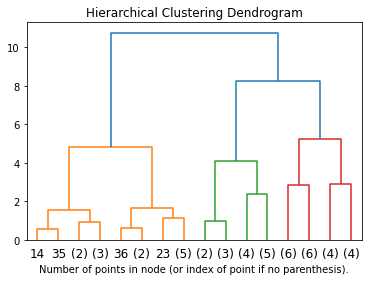

In [60]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = df_test[['number_of_children', 'number_of_people', 'household_income']]
X_scaled = scaler.transform(X)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_scaled)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [53]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_clusters[['number_of_children', 'number_of_people', 'household_income']])
df_clusters['segment'] = kmeans.labels_
df_clusters.head()

,mapped_tv2_hhid,number_of_children,number_of_people,household_income,segment
0,b0bea64399d711eaba32027f79c9c2a6,0,2,367590,0
28,90daa41bff3f11eba98a5b2026e1337f,6,8,119330,1
33,d6ccf0c9fd7311eaadb406bc760af1b7,2,4,192565,2
60,e5212e2e72b511eca933413299c8771d,4,6,397801,0
61,74c2fd06b7b011eb97ec27c2f91490d9,0,1,184226,2


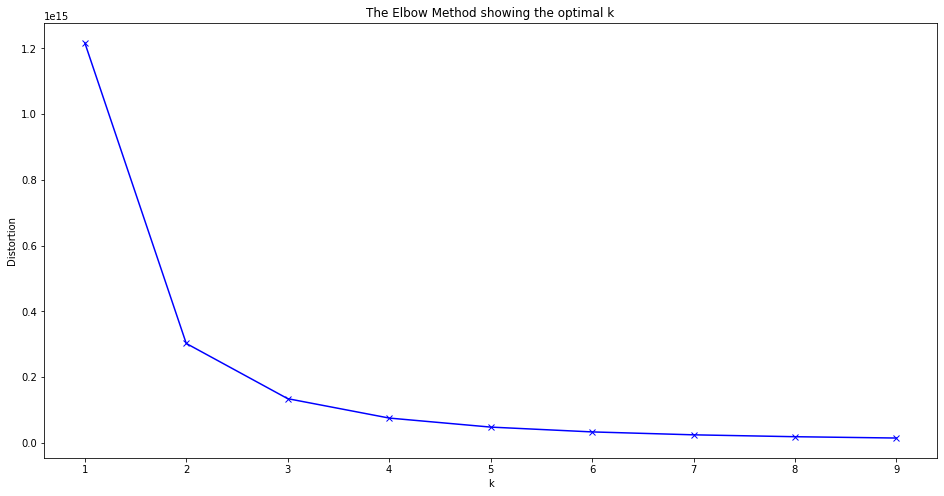

In [52]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_clusters[['number_of_children', 'number_of_people', 'household_income']]) #using full df 94,355 rows
    distortions.append(kmeanModel.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## ✅️ Metrics

Running full query to get final metrics:
- exp_visited	
- exp_hh	
- ctrl_visited	
- ctrl_hh	
- exp_vr=exp_visited/exp_hh	
- ctrl_vr=ctrl_visited/ctrl_hh 
- uplift=(exp_visited/exp_hh - ctrl_visited/ctrl_hh)/ (ctrl_visited/ctrl_hh)

for March data from Drizly (client 9306)

Crosswalk week: yy='2022', mm='03',dd='28' <br>
Campaing dates: dateto='2022-03-31', datefrom='2022-03-01'

### Looking at some examples first 

In [274]:
# Example 1 ['mapped_tv2_hhid']=='ec18256904b211ec9357b51dff46bb02'
# print('number of events for this hh:', len(df_control_march[df_control_march['mapped_tv2_hhid']=='ec18256904b211ec9357b51dff46bb02']))
# df_control_march[df_control_march['mapped_tv2_hhid']=='ec18256904b211ec9357b51dff46bb02'].groupby(['mapped_tv2_hhid', 'crosswalk_region', 'city']).count()

In [277]:
# Example 2: ['mapped_tv2_hhid']=='0003103b3d4811ec90fec1debfdcaebf'
# df_control_march[df_control_march['mapped_tv2_hhid']=='0003103b3d4811ec90fec1debfdcaebf']

In [276]:
visited_count=df_control_march.assign(result = np.where((df_control_march['event_class']=='response') & (df_control_march['event']=='all response'),1,0))
visited_count[visited_count['mapped_tv2_hhid']=='0003103b3d4811ec90fec1debfdcaebf']

,mapped_tv2_hhid,crosswalk_region,city,state,datadatetime,localdatetime,day,isp,event_class,event,result
261592,0003103b3d4811ec90fec1debfdcaebf,US/east-coast/new-york-ny,THEBRONX,NY,2022-03-04 17:39:23.000,2022-03-04 12:39:23.000,2022-03-04 00:00:00.000,VERIZONFIOS,response,all response,1
261593,0003103b3d4811ec90fec1debfdcaebf,US/east-coast/new-york-ny,THEBRONX,NY,2022-03-04 17:39:23.000,2022-03-04 12:39:23.000,2022-03-04 00:00:00.000,VERIZONFIOS,response,purchase,0
261594,0003103b3d4811ec90fec1debfdcaebf,US/east-coast/new-york-ny,THEBRONX,NY,2022-03-04 17:39:23.000,2022-03-04 12:39:23.000,2022-03-04 00:00:00.000,VERIZONFIOS,response,open,0


### Counting hhs and visits for control group
update 24 Aug - this section no longer makes sense but I want to save the code

In [20]:
# Counting total events per hh in control group
# ctrl_events=df_control_march.groupby(
#     ['mapped_tv2_hhid', 'crosswalk_region', 'city'],
#     as_index=False
#     ).event.count().rename(columns={'event':'ctrl_hh'})

# print("number of events:", ctrl_events['ctrl_hh'].sum())
# print("number of hhs:", len(ctrl_events))
# ctrl_events.head()

In [21]:
# Counting visits per hh in control group !!
#    ctrl_visits = np.where((
#        df_control_march['event_class']=='response') & (df_control_march['event']=='all response'),1,0)\
#    .groupby(['mapped_tv2_hhid', 'crosswalk_region', 'city'],as_index=False).ctrl_visited.sum()

# print("number of hhs:", len(ctrl_visits))
# ctrl_visits.head()

In [22]:
# Merging the 2 metrics in one df & calculating visit rate
# df_ctrl_metrics=ctrl_events.merge(ctrl_visits, how='left', on=['mapped_tv2_hhid', 'crosswalk_region', 'city'])
#df_ctrl_metrics['ctrl_vr']=df_ctrl_metrics['ctrl_visited']/df_ctrl_metrics['ctrl_hh'] #!! I think this needs to be added in the spreadsheet/dashboard or once the grouping is selected

# print("number of hhs:", len(df_ctrl_metrics))
# df_ctrl_metrics.head()

In [268]:
# Another version of creating counting visits per hh in control group
# df_control_march.assign(cond=((df_control_march['event_class']=='response') & (df_control_march['event']=='all response')))\
#    .groupby(['mapped_tv2_hhid', 'crosswalk_region', 'city'],).agg(ctrl_visited=('cond','sum'))